## N° Valores Propios > 0

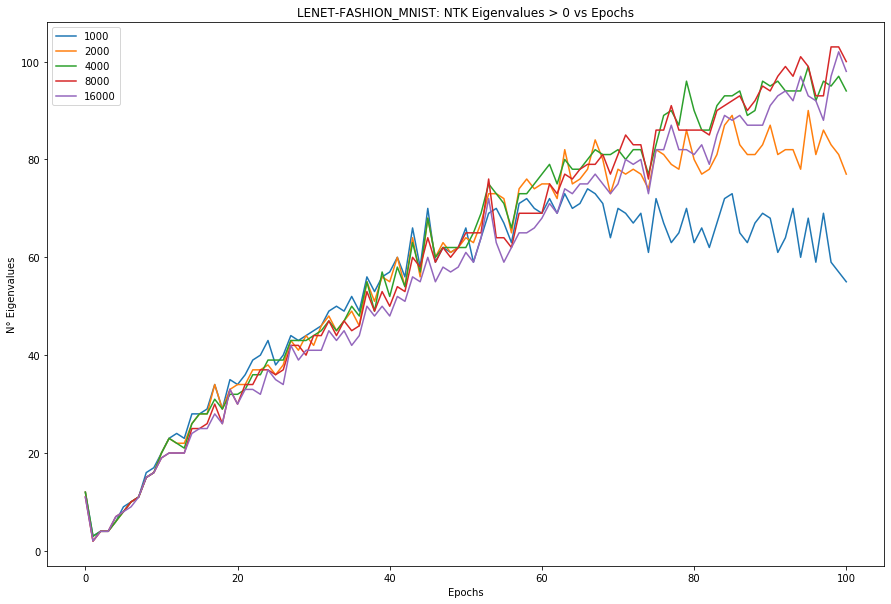

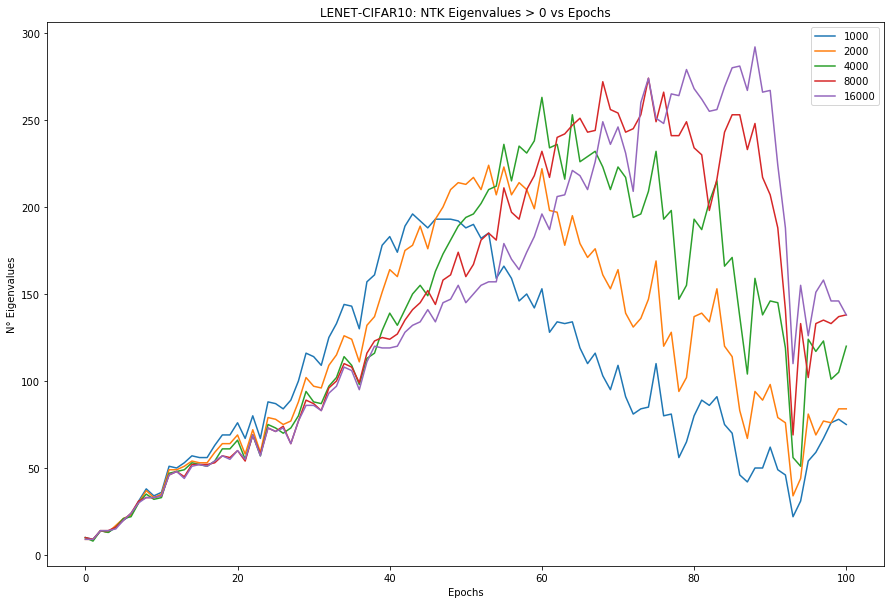

In [1]:
import numpy as np
import matplotlib.pyplot as plt


plt.show()
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

def print_results(arch, dataset, root="eigen", epochs=100, seed=123):
    plot_results = []
    for s in [1000,2000,4000, 8000,16000]:
        result = []
        vectors = []
        num_vals = []
        for i in range(epochs + 1):
            vals = np.load(f"{root}/eigvals_{arch}|{dataset}|{i}_{seed}_{s}.npy")
            trace = np.load(f"{root}/trace_{arch}|{dataset}|{i}_{seed}_{s}.npy")
            n_vals, *_ = vals[vals>0].shape
            num_vals.append(n_vals)

        #vectors = np.vstack(vectors)
        #mat = np.vstack(result)
        plot_results.append(num_vals)
        #print(result)
    plt.figure(figsize=(15, 10))
    #plt.imshow(mat.T, cmap='hot')
    #plt.show()
    plt.title(f"{arch.upper()}-{dataset.upper()}: NTK Eigenvalues > 0 vs Epochs")
    for i, p in enumerate(plot_results):
        plt.plot(list(range(epochs+1)),p, label=[1000,2000,4000,8000,16000][i])
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("N° Eigenvalues")
    

print_results("lenet","fashion_mnist")
print_results("lenet","cifar10")

In [7]:
a = np.load(f"ckpts/ckpoint_lenet|cifar10|0_123.npy", allow_pickle=True)

In [24]:
from operator import mul
result = 0
for k, v in a[()].items():
    for k1, v1 in v.items():
        if k1 == "kernel":
            temp_sum = 1
            for l in v1.shape:
                temp_sum *= l
            result += temp_sum
        else:
            result += v1.shape[0]
            
print(result)

136121


In [20]:
result

0

## Eigenvalue weight

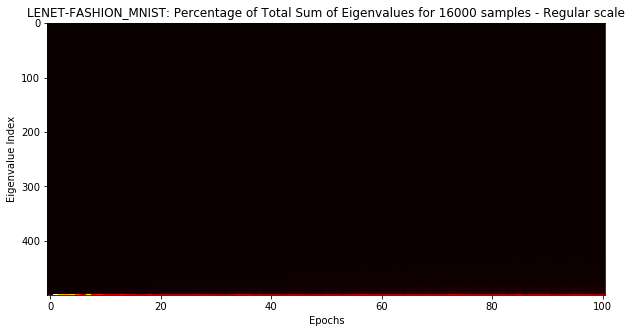

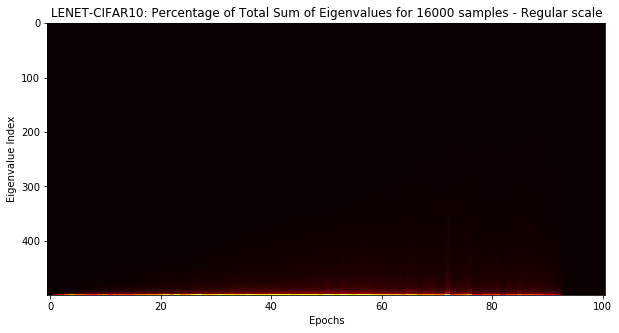

In [4]:
#from celluloid import Camera

def eigen_weight(arch, dataset, root="eigen", n_samples=16000, epochs=100, seed=123, logscale=True):
    plot_results = []

    result = []
    plt.figure(figsize=(10, 5))
    #camera = Camera(fig)
    for i in range(epochs + 1):
        trace = np.load(f"{root}/trace_{arch}|{dataset}|{i}_{seed}_{n_samples}.npy")
        vals = np.load(f"{root}/eigvals_{arch}|{dataset}|{i}_{seed}_{n_samples}.npy")
        vals = np.expand_dims(vals,0)
        #vals = vals.apply(lambda x: np.log(1+x))
        if logscale:
            vals = np.log(1+vals)
            vals = vals/vals.sum() #trace
        
        result.append(vals)
        mat = np.vstack(result)
        method = "Log" if logscale else "Regular"
    plt.title(f"{arch.upper()}-{dataset.upper()}: Percentage of Total Sum of Eigenvalues for {n_samples} samples - {method} scale")
    plt.xlabel("Epochs")
    plt.ylabel("Eigenvalue Index")
    plt.imshow(mat.T, cmap='hot', aspect="auto")

        #camera.snap()
    #animation = camera.animate()
    #animation.save('heatmap.gif', writer = 'imagemagick')
            
eigen_weight("lenet","fashion_mnist",logscale=False)
eigen_weight("lenet","cifar10",logscale=False)

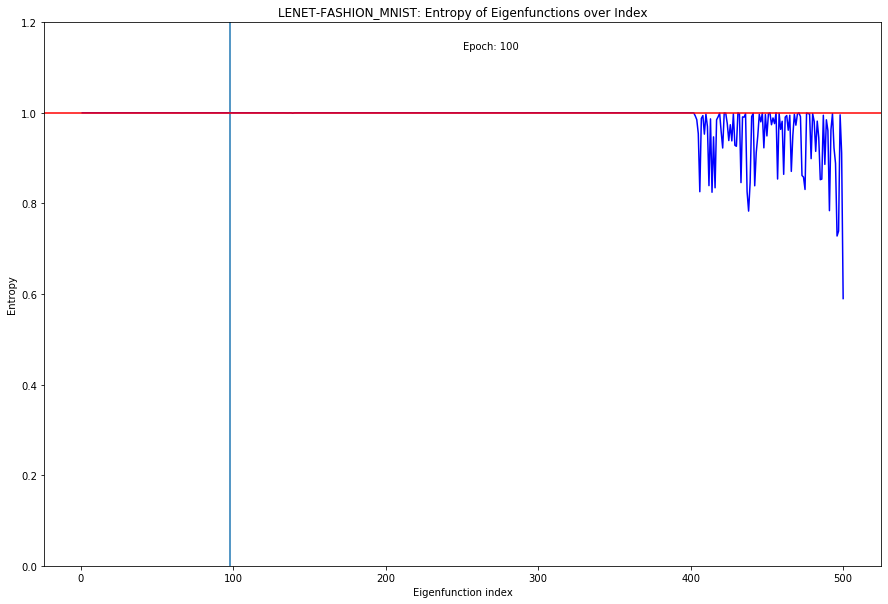

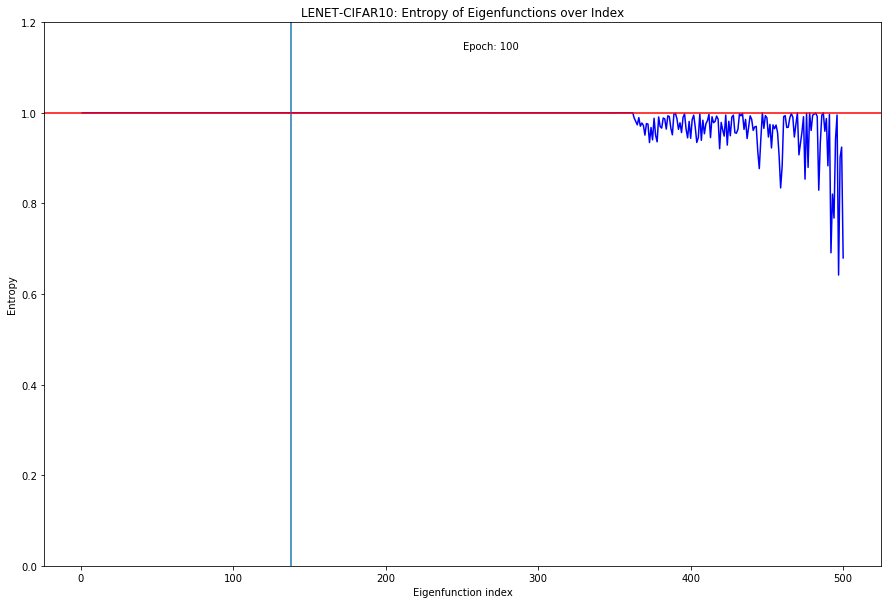

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from scipy.stats import entropy
plt.show()
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

def binarize_eigenfunctions(eigenfunction):
    return ((np.sign(eigenfunction) + 1) // 2).astype(float)

def eigenvec_entropy(arch, dataset, n_samples=1000, root="eigen", epochs=100, seed=123):
    plot_results = []
    s = n_samples
    result = []
    vectors = []
    num_vals = []
    fig, ax = plt.subplots(figsize=(15, 10))
    camera = Camera(fig)
    max_ent = 0.0
    for i in range(epochs + 1):
        result = []
        vals = np.load(f"{root}/eigvals_{arch}|{dataset}|{i}_{seed}_{s}.npy")
        n_vals, *_ = vals[vals>0].shape
        vecs = np.load(f"{root}/eigvecs_{arch}|{dataset}|{i}_{seed}_{s}.npy")
        #vecs = np.expand_dims(vecs, 0)
        for v in vecs:
            temp = binarize_eigenfunctions(v)
            
            p = temp.sum()/temp.shape[0]
            if p == 0 or p == 1:
                entrop = 0.0
            else:
                entrop = -p*np.log2(p)-(1-p)*np.log2(1-p)
            if entrop>max_ent:
                max_ent = entrop
            result.append(entrop)

        plt.title(f"{arch.upper()}-{dataset.upper()}: Entropy of Eigenfunctions over Index")
        ax.text(0.5, 0.95, f'Epoch: {i}', transform=ax.transAxes)
        plt.plot(list(range(1,501)),result, color="blue")
        plt.axvline(x=n_vals)
        plt.axhline(y=1.0, color="red")
        plt.xlabel("Eigenfunction index")
        plt.ylabel("Entropy")
        plt.ylim((0,1.2))
        camera.snap()
    animation = camera.animate()
    animation.save(f'entropy_{arch}_{dataset}_{s}.gif', writer = 'imagemagick')
    

for dataset in ['fashion_mnist',"cifar10"]:
    for n_samples in [16000]:
        eigenvec_entropy("lenet",dataset,n_samples=n_samples)

## Accuracy, Loss

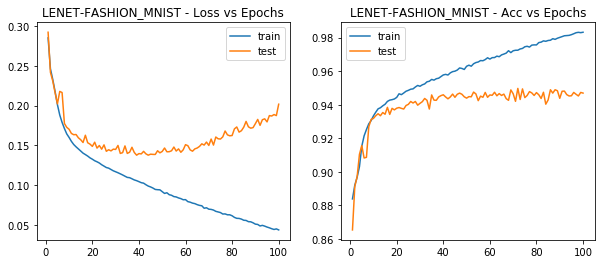

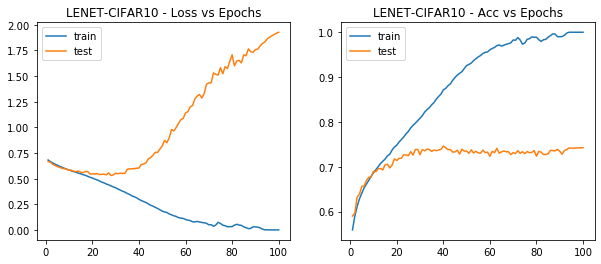

In [50]:
def print_stats(arch, dataset, epochs=100, root="stats",seed=123):
    result = []
    vectors = []
    num_vals = []
    for i in range(1,epochs + 1):
        vals = np.load(f"{root}/{arch}|{dataset}|{i}_{seed}.npy", allow_pickle=True)
        result.append(vals)
    
    
    def get_data(split="train", metric="loss"):
        r = []
        for d in result:
            #print(d[()], split, metric)
            r.append(d[()][split][metric])
        return r
    
    x = list(range(1,epochs+1))
    fig, axs = plt.subplots(1, 2,figsize=(10, 4))

    for i, metric in enumerate(['loss','acc']):
        axs[i].set_title(f"{arch.upper()}-{dataset.upper()} - {metric.capitalize()} vs Epochs")
        for split in ['train','test']:
            axs[i].plot(x, get_data(split, metric), label=split)
        axs[i].legend()

print_stats("lenet", "fashion_mnist")
print_stats("lenet", "cifar10")

In [63]:
for i in range(50):
    v1 = vectors[i][-1]
    v2 = vectors[i+1][-1]
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    print(np.linalg.norm(v1-v2))

0.65327245
0.30437192
1.995421
0.14694376
1.9804515
1.96378
0.8785385
0.6574625
0.25792104
1.9837958
1.9776752
0.24991237
0.46210524
0.25483334
0.3098303
0.2563514
1.9468937
0.448505
1.9783924
0.41487712
0.51089
1.9453804
1.9536664
1.9393138
0.41607577
0.3465347
0.40740588
1.949393
0.40081897
1.9474251
0.49506
1.9211969
1.9669416
0.50956845
0.582284
0.48933032
0.56688225
0.570959
1.96815
1.9668331
0.44607398
1.9064304
1.9145694
0.4002596
0.47034428
1.9275205
0.4331052
1.9609835
1.9385512
1.9556891
